In [1]:
import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython

#### Importing the data

In [24]:
!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=9cfeb02f-85ab-4801-a9a7-e75b0cbe2170
To: /content/Images for project.zip
100% 1.42G/1.42G [00:12<00:00, 112MB/s]


In [21]:
!unzip -q "/content/Images for project.zip" -d /content/

replace /content/__MACOSX/Images for project/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [29]:
!rm '/content/Images for project.zip'

#### Sorting the images into separate train-val-test folders

In [30]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

In [31]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [32]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [33]:
proportion = {
    'train': 0.75,
    'val': 0.05,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

train    0.732221
test     0.191945
val      0.075835
Name: split, dtype: float64

In [35]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

/content/Images for project/img?imageId=4030  doesn't exist
/content/Images for project/img?imageId=8364  doesn't exist
/content/Images for project/img?imageId=2767  doesn't exist
/content/Images for project/img?imageId=4031  doesn't exist
/content/Images for project/img?imageId=5399  doesn't exist
/content/Images for project/img?imageId=2766  doesn't exist
/content/Images for project/img?imageId=6724  doesn't exist
/content/Images for project/img?imageId=4505  doesn't exist
/content/Images for project/img?imageId=8362  doesn't exist
/content/Images for project/img?imageId=8363  doesn't exist


#### Creating the model

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=60,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                     zoom_range=0.3,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical',
        target_size = (224,224))

val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = (224,224))

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = (224,224))


Found 12099 images belonging to 114 classes.
Found 1254 images belonging to 114 classes.
Found 3173 images belonging to 114 classes.


In [37]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
# need to change here

class PlotMetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        # Plot loss
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Show plot
        plt.tight_layout()
        plt.show()

# Create an instance of the custom callback
plot_metrics_callback = PlotMetricsCallback()



# Define a LambdaCallback to clear the output
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)


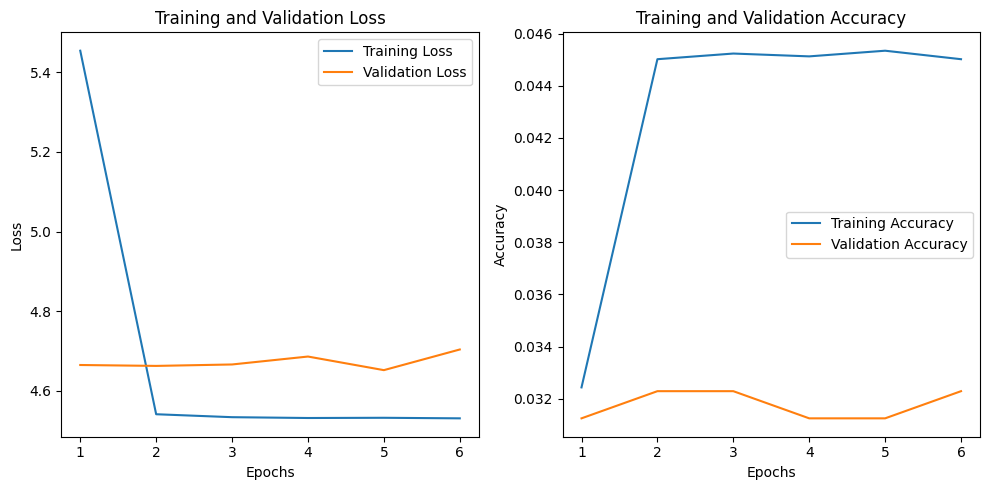

289/289 [==============================] - 154s 533ms/step - loss: 4.5306 - accuracy: 0.0450 - val_loss: 4.7036 - val_accuracy: 0.0323
Epoch 7/10
 95/289 [========>.....................] - ETA: 1:38 - loss: 4.5420 - accuracy: 0.0385

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
n_classes = 114

for layer in model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          steps_per_epoch=int(train_generator.n/batch_size),
          validation_steps = int(val_generator.n/batch_size),
          callbacks=[clear_output_callback, plot_metrics_callback])


In [ ]:
model.save_weights('/content/drive/MyDrive/Nova IMS/DL/Project/resnet_weights_baseline_19_03.h5')

#### Further modeling

In [40]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False

# Flatten the output of the VGG16 network because it is a 2D array
flatten = layers.Flatten()(vgg.output)

# Add a fully connected layer with 1024 neurons
dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.5)(dense)

# Add a fully connected layer with 256 neurons
dense = layers.Dense(256, activation='relu')(dense)
dropout = Dropout(0.5)(dense)

# We have 114 classes so we need a dense layer with 114 neurons
output = layers.Dense(114, activation='softmax')(dense)

# Create a model
model = models.Model(vgg.input, output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [42]:
# Train the model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

Epoch 1/10
379/379 [==============================] - 214s 565ms/step - loss: 4.5626 - accuracy: 0.0496 - val_loss: 4.6065 - val_accuracy: 0.0439
Epoch 2/10
379/379 [==============================] - 209s 550ms/step - loss: 4.2871 - accuracy: 0.0688 - val_loss: 4.4079 - val_accuracy: 0.0566
Epoch 3/10
379/379 [==============================] - 208s 548ms/step - loss: 4.1713 - accuracy: 0.0774 - val_loss: 4.2941 - val_accuracy: 0.0797
Epoch 4/10
379/379 [==============================] - 212s 560ms/step - loss: 4.0789 - accuracy: 0.0922 - val_loss: 4.2698 - val_accuracy: 0.0813
Epoch 5/10
379/379 [==============================] - 212s 558ms/step - loss: 4.0069 - accuracy: 0.0995 - val_loss: 4.1700 - val_accuracy: 0.0949
Epoch 6/10
379/379 [==============================] - 203s 535ms/step - loss: 3.9411 - accuracy: 0.1079 - val_loss: 4.1259 - val_accuracy: 0.0973
Epoch 7/10
379/379 [==============================] - 205s 541ms/step - loss: 3.8945 - accuracy: 0.1151 - val_loss: 4.0923 -

In [43]:
model.save_weights('/content/vgg16-1024-256.h5')